# Baseline Model – XGBoost for Short-Range Wind Power Forecasting

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
wtb_features = pd.read_csv("../data/processed/wtb_features.csv")

## 1. Prepare Data for Modeling

In [13]:
wtb_features = wtb_features.sort_values("Timestamp")

target = 'Patv'
drop_cols = ['Patv', 'Timestamp', 'TurbID']
X = wtb_features.drop(columns=drop_cols)
y = wtb_features[target]

## 2. XGBoost + TimeSeriesSplit

In [14]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import joblib

tscv = TimeSeriesSplit(n_splits=5)

xgb_model = XGBRegressor(tree_method='hist', device='cuda', random_state=42)

param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X, y)

y_pred = grid_search.predict(X)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


## 3. Model Evaluation

In [15]:
mae = mean_absolute_error(y, y_pred)
rmse = root_mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("XGBoost Baseline Results")
print(f"Best Params: {grid_search.best_params_}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

XGBoost Baseline Results
Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
MAE: 41.17
RMSE: 65.72
R²: 0.977


### XGBoost Baseline Results – Short-Range Forecasting

To improve upon the linear ElasticNet baseline, I trained a more expressive model using **XGBoost**, a gradient-boosted tree ensemble. The model was optimized via `GridSearchCV` using `TimeSeriesSplit` (5 folds) to respect the temporal nature of the data.

**Best Hyperparameters**:
- `learning_rate`: 0.1
- `max_depth`: 6
- `n_estimators`: 200

**Performance Metrics**:
- **MAE**: 41.17 kW
- **RMSE**: 65.72 kW
- **R²**: 0.977

**Interpretation**

- Compared to ElasticNet (MAE ≈ 128 kW, R² ≈ 0.81), XGBoost **significantly improves** prediction accuracy, reducing the average error by nearly **threefold**.
- An R² score of **0.977** indicates that the model explains **97.7% of the variance** in the power output — an excellent result for short-range forecasting at the 10-minute scale.
- The **scatterplot of predicted vs actual values** shows very tight alignment along the ideal diagonal, confirming that XGBoost effectively captures the nonlinear dynamics of wind turbine behavior.

## 4. Save Trained Model

In [16]:
joblib.dump(grid_search.best_estimator_, "../models/xgboost_model.joblib")
print("XGBoost model saved as 'xgboost_model.joblib'")

XGBoost model saved as 'xgboost_model.joblib'


In [17]:
import json

metrics = {
    'best_params': grid_search.best_params_,
    'MAE': round(mae, 2),
    'RMSE': round(rmse, 2),
    'R2': round(r2, 3)
}

with open("../results/xgboost_scores.json", "w") as f:
    json.dump(metrics, f, indent=4)

## 5. Plot Predictions vs True

c:\Users\Ningo\Desktop\S2R-Wind\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


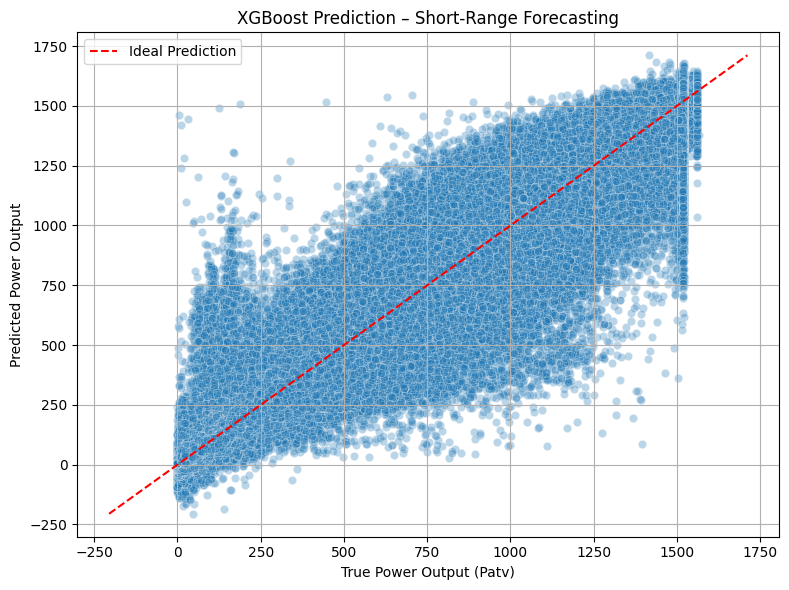

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.3)

# Ideal line
min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Prediction')

plt.xlabel("True Power Output (Patv)")
plt.ylabel("Predicted Power Output")
plt.title("XGBoost Prediction – Short-Range Forecasting")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
